In [1]:
import pandas as pd

In [2]:
eligible_companies = pd.read_csv('companies_eligible_to_financial_dataset_2024-04-19_14-47-55.csv')
eligible_companies.head()

,Unnamed: 0,cik,company,label,ticker,gurufocus-company-name,gurufocus-stockid,filing_date,cik-equal-gurufocus-cik,first_match
0,0,1800,ABBOTT LABORATORIES,False,ABT,Abbott Laboratories,US066X,2021-02-19,True,NaN
1,1,2488,ADVANCED MICRO DEVICES INC,False,AMD,Advanced Micro Devices Inc,US022E,2021-01-29,True,NaN
2,2,2491,"BALLY TECHNOLOGIES, INC.",False,BYI,Bally Technologies Inc (Delisted),US06R5,2014-08-29,True,NaN
3,3,2601,AEROFLEX INC,False,ARXX,Aeroflex Inc (Delisted),US026H,2006-09-13,True,NaN
4,4,2969,AIR PRODUCTS & CHEMICALS INC /DE/,False,APD,Air Products & Chemicals Inc,US06DU,2021-11-18,True,NaN


In [3]:
eligible_companies['label'].value_counts()

label
False    5291
True      126
Name: count, dtype: int64

In [32]:
len(eligible_companies)

5417

In [5]:
eligible_companies_with_two_tickers = eligible_companies[eligible_companies['first_match'].notnull()]
len(eligible_companies_with_two_tickers)

492

In [2]:
one_ticker_case_financial_data_directory = 'financial_data'
two_ticker_case_financial_data_directory = 'financial_data_two_tickers_case'
final_financial_data_directory = 'final_financial_data'

In [21]:
import os

cnt = 0
for index, row in eligible_companies_with_two_tickers.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    
    filepath = f'./{two_ticker_case_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
    
    if not os.path.exists(filepath):
        print(f'{filepath} does not exist')
    else:
        cnt += 1
print(cnt)

492


TODO: copy files to financial_data directory

In [26]:
# copy files to financial_data directory
import shutil
for index, row in eligible_companies_with_two_tickers.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    
    filepath = f'{two_ticker_case_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
    shutil.copy(filepath, f'./final_financial_data/{cik}-{gurufocus_stockid}_{ticker}.csv')


In [27]:
eligible_companies_without_two_tickers = eligible_companies[eligible_companies['first_match'].isnull()]

In [31]:
for index, row in eligible_companies_without_two_tickers.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    
    filepath = f'{one_ticker_case_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
    shutil.copy(filepath, f'./final_financial_data/{cik}-{gurufocus_stockid}_{ticker}.csv')

In [28]:
eligible_companies_copy = eligible_companies.copy()

In [29]:
def drop_columns_after_ttm_or_preliminary(df):
    try:
        found_ttm = False
        try:
            ttm_index = df.columns.get_loc('TTM')
            found_ttm = True
            df = df.iloc[:, :ttm_index]
        except:
            pass
            
        if not found_ttm:
            try:
                ttm_preliminary_string = 'TTM  Preliminary'
                ttm_index = df.columns.get_loc(ttm_preliminary_string)
                found_ttm = True
                df = df.iloc[:, :ttm_index]
            except:
                print(f'No \'TTM  Preliminary\' column in {filename}')
            if not found_ttm: 
                try:
                    
                    preliminary_string = 'Preliminary'
                    preliminary_index = None
                    for i, s in enumerate(df.columns):
                        if preliminary_string in s:
                            preliminary_index = i
                            break
                            
                    df = df.iloc[:, :preliminary_index + 1]
                    last_column_name = df.columns[-1]
                    split_date = last_column_name.split(' ')
                    updated_col_name = f'{split_date[0]} {split_date[1]}'
                    
                    df.rename(columns={last_column_name: updated_col_name}, inplace=True)
                    
                    print(f'No TTM but found Preliminary in {filename}')
                except:
                    print(f'No Preliminary column in {filename}')
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')
    
    return df

In [31]:
import datetime

exception_during_date_comparison = []
update_list = []
not_found_ttm_but_found_preliminary = []

for index, row in eligible_companies_copy.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    filing_date = row['filing_date']
    
    filename = f'{cik}-{gurufocus_stockid}_{ticker}.csv'
    filepath = f'{final_financial_data_directory}/{filename}'
        
    try:
        df = pd.read_csv(filepath)
        
        df = drop_columns_after_ttm_or_preliminary(df)
        
        last_column_name = df.columns[-1]
        split_date = last_column_name.split(' ')
        month, year = split_date[0], int(split_date[1])
        
        if 0 <= year <= 9:
            year = f'200{year}'
        elif 10 <= year <= 24:
            year = f'20{year}'
        elif year > 24:
            year = f'19{year}'
            
        gurufocus_last_data_date = datetime.datetime.strptime(f'{month} {year}', '%b %Y')
        
        filing_date = filing_date[:7]
        filing_date = datetime.datetime.strptime(f'{filing_date}', '%Y-%m')

        difference_in_months = int((gurufocus_last_data_date - filing_date).days / 30)
        
        eligible_companies_copy.loc[eligible_companies_copy['cik'] == cik, 'difference_in_months'] = difference_in_months
        
    except Exception as ex:
        print(f'Exception: {cik}, {gurufocus_stockid}, {ticker}, {str(ex)}')
        exception_during_date_comparison.append([cik, gurufocus_stockid, ticker, str(ex)])

Exception: 1766526, US26IG, TECTP.PFD, invalid literal for int() with base 10: 'Period'


In [11]:
len(exception_during_date_comparison)

1

In [32]:
counts_df = eligible_companies_copy['difference_in_months'].value_counts()
counts_df = counts_df.reset_index()
counts_df.columns = ['difference_in_months', 'count']
counts_df.head(10)

,difference_in_months,count
0,-3.0,1398
1,34.0,1190
2,-2.0,825
3,33.0,676
4,22.0,325
5,9.0,171
6,21.0,145
7,-4.0,113
8,10.0,85
9,45.0,38


In [33]:
mask = (counts_df['difference_in_months'] > -12) & (counts_df['difference_in_months'] < 36)
below_36_and_above_minus_12 = counts_df[mask]
below_36_and_above_minus_12['count'].sum()

5078

In [128]:
counts_df = eligible_companies_copy['difference_in_months'].value_counts()
# set column names
counts_df = counts_df.reset_index()
counts_df.columns = ['difference_in_months', 'count']
counts_df.head()

,difference_in_months,count
0,34.0,1172
1,33.0,650
2,6.0,519
3,0.0,514
4,3.0,337


In [130]:
mask = (counts_df['difference_in_months'] > -12) & (counts_df['difference_in_months'] < 36)
below_36_and_above_minus_12 = counts_df[mask]
below_36_and_above_minus_12['count'].sum()

5055

(array([4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 6.000e+00, 2.500e+01,
        1.000e+00, 5.000e+00, 5.000e+00, 1.600e+01, 1.519e+03, 8.550e+02,
        5.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 1.890e+02, 8.500e+01,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.590e+02, 3.300e+02,
        4.000e+00, 2.000e+00, 2.000e+00, 1.900e+01, 1.866e+03, 9.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 5.800e+01, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 3.600e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

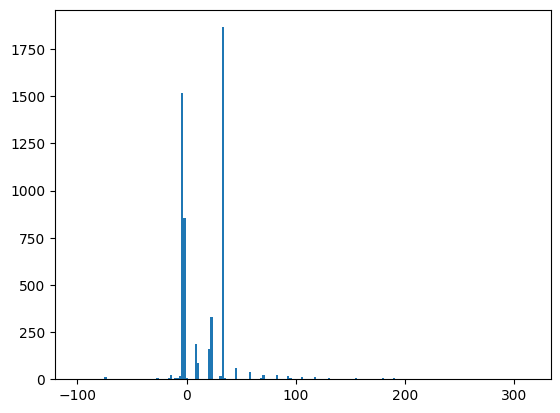

In [21]:
import matplotlib.pyplot as plt

plt.hist(eligible_companies_copy['difference_in_months'], bins=200)

(array([4.000e+00, 4.000e+00, 4.000e+00, 1.100e+01, 4.000e+00, 0.000e+00,
        2.000e+00, 4.000e+00, 6.000e+00, 4.000e+00, 3.700e+01, 2.395e+03,
        1.100e+01, 2.750e+02, 4.900e+02, 2.700e+01, 1.877e+03, 6.200e+01,
        5.000e+00, 3.600e+01, 3.000e+01, 3.000e+00, 2.300e+01, 2.300e+01,
        1.200e+01, 4.000e+00, 1.500e+01, 7.000e+00, 1.000e+00, 4.000e+00,
        8.000e+00, 2.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 7.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-100.  ,  -91.74,  -83.48,  -75.22,  -66.96,  -58.7 ,  -50.44,
         -42.18,  -33.92,  -25.66,  -17.4 ,   -9.14,   -0.88,    7.38,
          15.64,   23.9 ,   32.16,   40.42,   48.68,   56.94,   65.2 ,
          73.46,   81.72,   89.98,   98.24,  106.5 ,  114.76,  123.02,
         131.28,  139.54,  147.8 ,  156.06,  164.32,  172.58,  180.84,
         189.1 ,  197

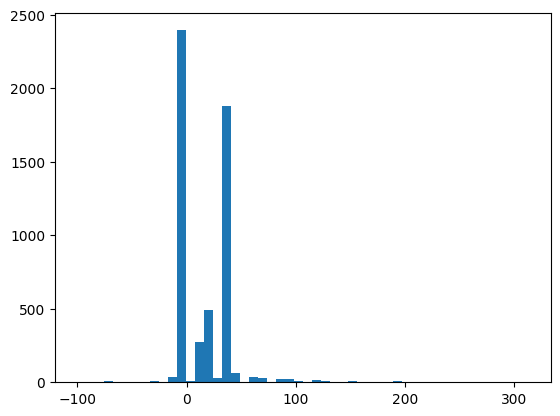

In [22]:
import matplotlib.pyplot as plt

plt.hist(eligible_companies_copy['difference_in_months'], bins=50)

Filter companies with difference_in_months between -12 and 36 to be sure that there is no mismatch between the gurufocus data and sec edgar data

In [24]:
mask = (eligible_companies_copy['difference_in_months'] > -12) & (eligible_companies_copy['difference_in_months'] < 36)
eligible_companies_in_eligible_range = eligible_companies_copy[mask]
eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
eligible_companies_in_eligible_range.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)

print(len(eligible_companies_in_eligible_range))
eligible_companies_in_eligible_range.head()

5078


C:\Users\grzeg\AppData\Local\Temp\ipykernel_35176\296199527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
C:\Users\grzeg\AppData\Local\Temp\ipykernel_35176\296199527.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_companies_in_eligible_range.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)


,Unnamed: 0,cik,company,label,ticker,gurufocus-company-name,gurufocus-stockid,filing_date,difference_in_months
0,0,1800,ABBOTT LABORATORIES,False,ABT,Abbott Laboratories,US066X,2021-02-19,34
1,1,2488,ADVANCED MICRO DEVICES INC,False,AMD,Advanced Micro Devices Inc,US022E,2021-01-29,35
2,2,2491,"BALLY TECHNOLOGIES, INC.",False,BYI,Bally Technologies Inc (Delisted),US06R5,2014-08-29,-2
4,4,2969,AIR PRODUCTS & CHEMICALS INC /DE/,False,APD,Air Products & Chemicals Inc,US06DU,2021-11-18,22
5,5,3153,ALABAMA POWER CO,False,ALPpQ.PFD,Alabama Power Co (Delisted),US0TUZ,2021-02-18,10


In [25]:
eligible_companies_in_eligible_range.to_csv('eligible_companies_in_eligible_range.csv', index=False)

In [26]:
eligible_companies_in_eligible_range['label'].value_counts()

label
False    4961
True      117
Name: count, dtype: int64

In [27]:
eligible_companies_in_eligible_range['label'].value_counts(normalize=True)

label
False    0.976959
True     0.023041
Name: proportion, dtype: float64

Percentage of the companies that are bankrupt is 0.023041 in comparison to initial percentage equal to 0.039921. Subset has shrink by one third.
that is pretty common: https://www.kaggle.com/code/marto24/bankruptcy-detection?scriptVersionId=56676526&cellId=13
maybe above code proposes way to handle imbalanced data? Augmentation?

In [7]:
import os
import matplotlib.pyplot as plt
import pandas as pd

rows_count_dict = []
for filename in os.listdir(final_financial_data_directory):
    df = pd.read_csv(f'{final_financial_data_directory}/{filename}')
    df_length = len(df)
    rows_count_dict.append({'filename': filename, 'rows': df_length})
    
rows_count = [d['rows'] for d in rows_count_dict]

In [8]:
filename_of_max_rows = max(rows_count_dict, key=lambda x:x['rows'])['filename']
filename_of_max_rows

'1666700-US077I_DD.csv'

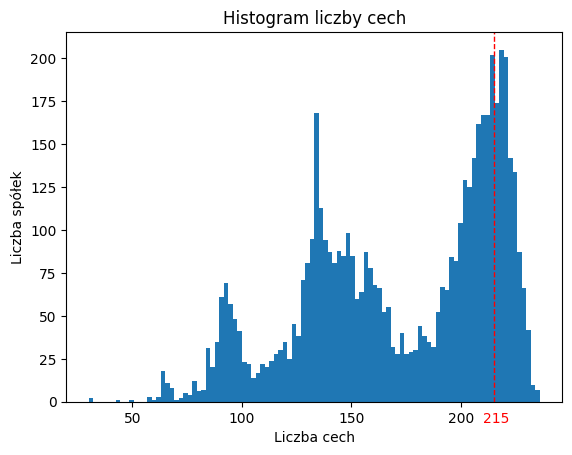

In [9]:
plt.hist(rows_count, bins=100)
plt.xlabel('Liczba cech')
plt.ylabel('Liczba spółek')
plt.title('Histogram liczby cech')
# draw a vertical line for the maximum number of documents
plt.axvline(x=215, color='r', linestyle='dashed', linewidth=1)
# print an x value for the maximum number of documents
plt.text(210, -12, '215', color = 'red')
plt.show()

In [18]:
# coutn of companies with more than 215 features
sum([1 for row in rows_count if row >= 120])

4756

### deleting duplicated rows from financial data

In [4]:
from collections import Counter
import os

row_headers_count = []

for filename in os.listdir(final_financial_data_directory):
    
    df = pd.read_csv(f'{final_financial_data_directory}/{filename}')
    df.drop(df.index[df.iloc[:, 1].duplicated(keep=False)], inplace=True)
    row_headers_count.extend(df.iloc[:, 1].tolist())
        
counts = Counter(row_headers_count)

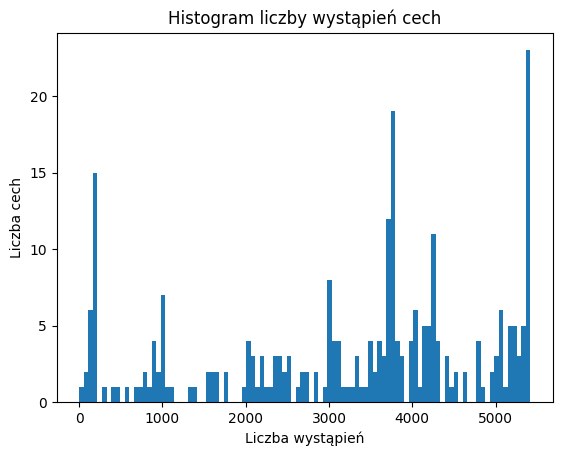

In [6]:
# print histogram of counts
import matplotlib.pyplot as plt
plt.hist(counts.values(), bins=100)
plt.xlabel('Liczba wystąpień')
plt.ylabel('Liczba cech')
plt.title('Histogram liczby wystąpień cech')
plt.show()

In [83]:
most_common_x_variables = list(enumerate(counts.most_common(200)))
most_common_x_variables 

[(0, ('Liabilities-to-Assets', 5418)),
 (1, ('Total Assets', 5418)),
 (2, ('Total Liabilities', 5418)),
 (3, ('Total Stockholders Equity', 5418)),
 (4, ('Total Equity', 5418)),
 (5, ('Forex Rate', 5418)),
 (6, ('Scaled Net Operating Assets', 5417)),
 (7, ('ROA %', 5416)),
 (8, ('Return-on-Tangible-Asset', 5416)),
 (9, ('Net Income Including Noncontrolling Interests', 5416)),
 (10, ('Net Income (Continuing Operations)', 5416)),
 (11, ('Net Income', 5416)),
 (12, ('Net Income From Continuing Operations', 5416)),
 (13, ('Cash Flow from Operations', 5415)),
 (14, ('Net Change in Cash', 5415)),
 (15, ('Free Cash Flow', 5415)),
 (16, ('Cash Flow from Others', 5413)),
 (17, ('Cash Flow from Financing', 5413)),
 (18, ('ROE %', 5392)),
 (19, ('Ending Cash Position', 5392)),
 (20, ('Beginning Cash Position', 5389)),
 (21, ('Cash Flow from Investing', 5380)),
 (22, ('Sloan Ratio %', 5371)),
 (23, ('FCF Margin %', 5354)),
 (24, ('Revenue', 5354)),
 (25, ('Asset Turnover', 5353)),
 (26, ('Debt-to-A

In [105]:
most_common_variables = [tup[0] for tup in counts.most_common(100)]

# save most common variables
with open('most_common_variables.txt', 'w') as f:
    for variable in most_common_variables:
        f.write(f'{variable}\n')

most_common_variables

['Liabilities-to-Assets',
 'Total Assets',
 'Total Liabilities',
 'Total Stockholders Equity',
 'Total Equity',
 'Forex Rate',
 'Scaled Net Operating Assets',
 'ROA %',
 'Return-on-Tangible-Asset',
 'Net Income Including Noncontrolling Interests',
 'Net Income (Continuing Operations)',
 'Net Income',
 'Net Income From Continuing Operations',
 'Cash Flow from Operations',
 'Net Change in Cash',
 'Free Cash Flow',
 'Cash Flow from Others',
 'Cash Flow from Financing',
 'ROE %',
 'Ending Cash Position',
 'Beginning Cash Position',
 'Cash Flow from Investing',
 'Sloan Ratio %',
 'FCF Margin %',
 'Revenue',
 'Asset Turnover',
 'Debt-to-Asset',
 'Retained Earnings',
 'Cash From Other Investing Activities',
 'Other Financing',
 'Long-Term Debt & Capital Lease Obligation',
 'Purchase Of Property, Plant, Equipment',
 'Common Stock',
 'Property, Plant and Equipment',
 'Pretax Income',
 'Total Receivables',
 'Capital Expenditure',
 'Depreciation, Depletion and Amortization',
 'Cash Flow Depreciat

In [106]:
counts.most_common(100)

[('Liabilities-to-Assets', 5418),
 ('Total Assets', 5418),
 ('Total Liabilities', 5418),
 ('Total Stockholders Equity', 5418),
 ('Total Equity', 5418),
 ('Forex Rate', 5418),
 ('Scaled Net Operating Assets', 5417),
 ('ROA %', 5416),
 ('Return-on-Tangible-Asset', 5416),
 ('Net Income Including Noncontrolling Interests', 5416),
 ('Net Income (Continuing Operations)', 5416),
 ('Net Income', 5416),
 ('Net Income From Continuing Operations', 5416),
 ('Cash Flow from Operations', 5415),
 ('Net Change in Cash', 5415),
 ('Free Cash Flow', 5415),
 ('Cash Flow from Others', 5413),
 ('Cash Flow from Financing', 5413),
 ('ROE %', 5392),
 ('Ending Cash Position', 5392),
 ('Beginning Cash Position', 5389),
 ('Cash Flow from Investing', 5380),
 ('Sloan Ratio %', 5371),
 ('FCF Margin %', 5354),
 ('Revenue', 5354),
 ('Asset Turnover', 5353),
 ('Debt-to-Asset', 5344),
 ('Retained Earnings', 5317),
 ('Cash From Other Investing Activities', 5305),
 ('Other Financing', 5296),
 ('Long-Term Debt & Capital Le

In [36]:
# list of chosen variables based on https://www.mdpi.com/1999-5903/14/8/244 & https://raw.githubusercontent.com/sowide/bankruptcy_dataset/main/american_bankruptcy_dataset.csv
chosen_variables = [
    'Total Current Assets',
    'Cost of Goods Sold',
    'Depreciation, Depletion and Amortization',
    'EBITDA',
    'Total Inventories',
    'Net Income',
    'Total Receivables',
    'Market Cap',
    'Total Assets',
    'Long-Term Debt',
    'EBIT',
    'Gross Profit',
    'Total Current Liabilities',
    'Retained Earnings',
    'Revenue',
    'Total Liabilities',
    'Total Operating Expense'
]

# save chosen variables
with open('chosen_variables.txt', 'w') as f:
    for variable in chosen_variables:
        f.write(f'{variable}\n')

In [74]:
len(chosen_variables)

17

In [87]:
# check if all chosen variables are present in the counts
for variable in chosen_variables:
    if variable not in most_common_variables:
        print(f'{variable} is not present in the counts')

Total Inventories is not present in the counts
Market Cap is not present in the counts


In [45]:
final_financial_data_processed_100_variables = 'final_financial_data_processed_100_variables'
final_financial_data_processed_17_variables = 'final_financial_data_processed_17_variables'
final_financial_data_in_date_range_directory = 'final_financial_data_in_date_range'

In [47]:
from collections import Counter

files_with_not_present_variables_count = 0

not_found_variables_per_file = []

for filename in os.listdir(final_financial_data_in_date_range_directory):
    df = pd.read_csv(f'{final_financial_data_in_date_range_directory}/{filename}')
    csv_variable = df.iloc[:, 1].tolist()
    cnt = 0
    for chosen_variable in chosen_variables:
        if chosen_variable not in csv_variable:
            cnt += 1
    
    not_found_variables_per_file.append(cnt)
        
not_found_counts = Counter(not_found_variables_per_file)
not_found_counts

Counter({0: 1845,
         1: 1422,
         9: 566,
         2: 394,
         10: 352,
         7: 128,
         3: 116,
         8: 75,
         11: 66,
         4: 59,
         5: 41,
         6: 12,
         12: 2})

In [48]:
not_found_counts = dict(sorted(not_found_counts.items()))
not_found_counts

{0: 1845,
 1: 1422,
 2: 394,
 3: 116,
 4: 59,
 5: 41,
 6: 12,
 7: 128,
 8: 75,
 9: 566,
 10: 352,
 11: 66,
 12: 2}

In [103]:
# count of files with up to 3 missing variables
sum([v for k, v in not_found_counts.items() if k <= 3])

4085

### get files with maximum of 3 lacking variables - it is ~17% of variables that will be empty

In [ ]:
# get files with maximum of 3 lacking variables
for filename in os.listdir(final_financial_data_directory):
    df = pd.read_csv(f'{final_financial_data_directory}/{filename}')
    csv_variable = df.iloc[:, 1].tolist()
    cnt = 0
    for chosen_variable in chosen_variables:
        if chosen_variable not in csv_variable:
            cnt += 1
    
    if cnt <= 3:
        shutil.copy(f'{final_financial_data_directory}/{filename}', f'{final_financial_data_processed_17_variables}/{filename}')

In [96]:
# most common variables
not_found_variables_per_file_most_common_vars = []

for filename in os.listdir(final_financial_data_directory):
    df = pd.read_csv(f'{final_financial_data_directory}/{filename}')
    csv_variable = df.iloc[:, 1].tolist()
    cnt = 0
    for chosen_variable in most_common_variables:
        if chosen_variable not in csv_variable:
            cnt += 1
    
    not_found_variables_per_file_most_common_vars.append(cnt)
        
not_found_counts_most_common_vars = Counter(not_found_variables_per_file_most_common_vars)
print(not_found_counts_most_common_vars)

Counter({0: 771, 1: 737, 2: 621, 3: 477, 4: 369, 5: 265, 6: 204, 31: 192, 32: 179, 33: 161, 7: 153, 34: 141, 8: 126, 35: 108, 30: 103, 36: 76, 11: 63, 9: 62, 37: 61, 10: 57, 38: 45, 39: 32, 40: 29, 12: 29, 20: 23, 14: 23, 21: 23, 18: 21, 42: 21, 13: 19, 41: 18, 27: 17, 56: 14, 19: 14, 16: 13, 29: 12, 55: 9, 49: 9, 17: 9, 22: 9, 15: 9, 28: 8, 44: 8, 23: 7, 48: 7, 24: 7, 43: 7, 46: 6, 57: 6, 45: 5, 53: 5, 52: 4, 26: 4, 51: 3, 54: 3, 50: 3, 25: 2, 47: 2, 58: 2, 60: 2, 74: 1, 76: 1, 65: 1})


In [97]:
# sort not_found_counts_most_common_vars by key
not_found_counts_most_common_vars = dict(sorted(not_found_counts_most_common_vars.items()))
not_found_counts_most_common_vars

{0: 771,
 1: 737,
 2: 621,
 3: 477,
 4: 369,
 5: 265,
 6: 204,
 7: 153,
 8: 126,
 9: 62,
 10: 57,
 11: 63,
 12: 29,
 13: 19,
 14: 23,
 15: 9,
 16: 13,
 17: 9,
 18: 21,
 19: 14,
 20: 23,
 21: 23,
 22: 9,
 23: 7,
 24: 7,
 25: 2,
 26: 4,
 27: 17,
 28: 8,
 29: 12,
 30: 103,
 31: 192,
 32: 179,
 33: 161,
 34: 141,
 35: 108,
 36: 76,
 37: 61,
 38: 45,
 39: 32,
 40: 29,
 41: 18,
 42: 21,
 43: 7,
 44: 8,
 45: 5,
 46: 6,
 47: 2,
 48: 7,
 49: 9,
 50: 3,
 51: 3,
 52: 4,
 53: 5,
 54: 3,
 55: 9,
 56: 14,
 57: 6,
 58: 2,
 60: 2,
 65: 1,
 74: 1,
 76: 1}

In [98]:
# count of files with up to 10 missing variables
sum([v for k, v in not_found_counts_most_common_vars.items() if k <= 10])

3842